# RoC Analysis

## Data Generation
* Fix a beta* value and number of predictors
* Create a Y vector using Bernoulli distribution for logit
* Create a X vector using normal distribution as i.i.ds

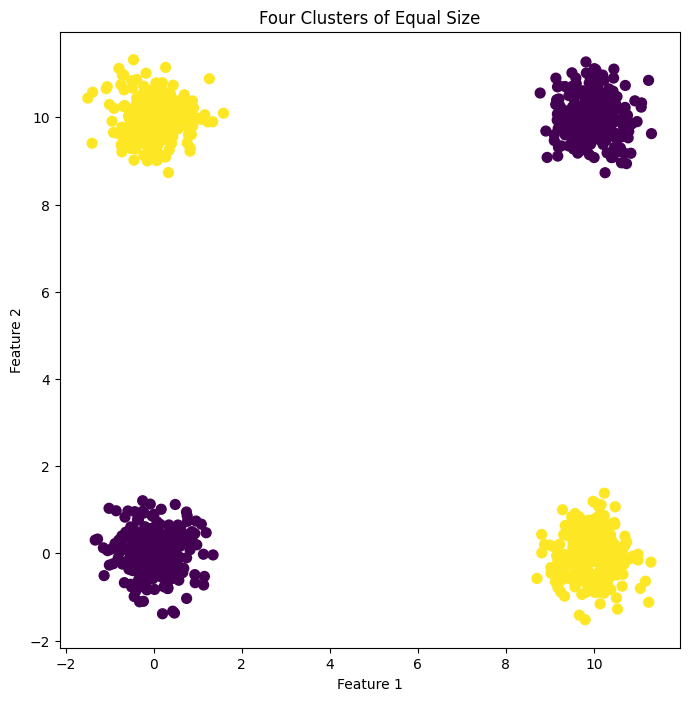

Training data shape: (800, 3), (800,)
Test data shape: (200, 3), (200,)


In [44]:
no_predictors = 2
no_samples = 1000
no_classes = 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

n_samples_per_cluster = 250
n_clusters = 4

# Create the clusters deterministically
np.random.seed(0) # for reproducibility

X = np.zeros((n_samples_per_cluster * n_clusters, 2))
y = np.zeros(n_samples_per_cluster * n_clusters)

# Cluster centers in corners of a square
centers = [[0, 0], [10, 0], [0, 10], [10, 10]]

# Assign points to clusters deterministically
for i in range(n_clusters):
    cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
    X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
    if i == 0 or i == 3:
        y[cluster_indices] = 0
    else:
        y[cluster_indices] = 1



#Visualize
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
plt.title('Four Clusters of Equal Size')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#add intercept to X
X = np.hstack((np.ones((X.shape[0], 1)), X))

# # shuffle data
# permutation = np.random.permutation(no_samples)
# X = X[permutation]
# y = y[permutation]


#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")





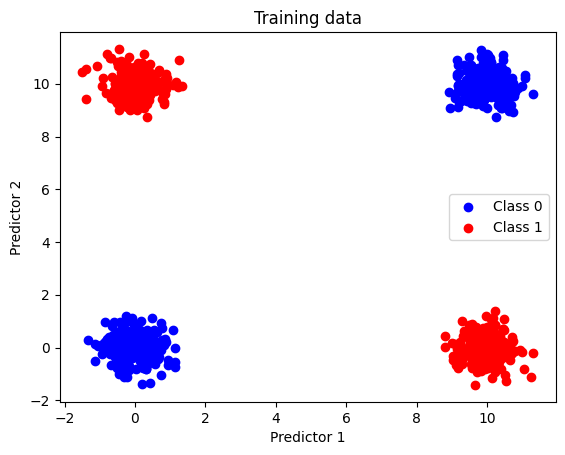

In [45]:
plt.figure()
plt.scatter(X_train[y_train == 0, 1], X_train[y_train == 0, 2], color='b', label='Class 0') 
plt.scatter(X_train[y_train == 1, 1], X_train[y_train == 1, 2], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Training data')
plt.show()

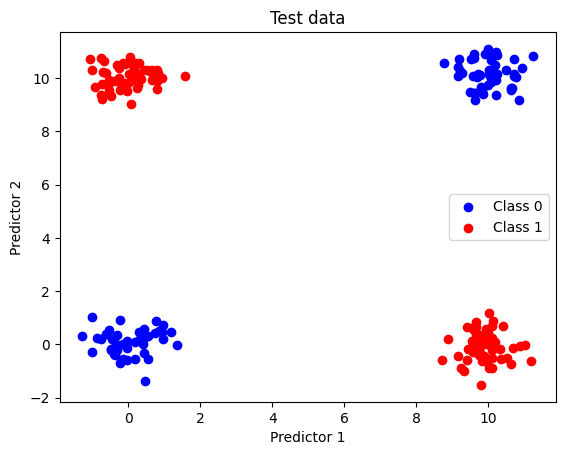

In [46]:
plt.figure()
plt.scatter(X_test[y_test == 0, 1], X_test[y_test == 0, 2], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 1], X_test[y_test == 1, 2], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Test data')
plt.show()

## Logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
clf = LogisticRegression(fit_intercept=False)
clf.fit(X_train, y_train)
beta_hat = clf.coef_[0]
beta_hat = beta_hat / np.linalg.norm(beta_hat)

# print('True beta: ', beta_star)
print('Estimated beta: ', beta_hat)
# print('Mean squared error: ', np.mean((beta_star - beta_hat) ** 2))

Estimated beta:  [-0.99611822  0.08729118  0.01134679]


## Standard RoC curve

In [48]:
# Plot the RoC curve
from sklearn.metrics import roc_curve
fpr_roc, tpr_roc, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])


## RoC curve by cost-sensitive learning

The following function fixes the threshold value. The input model to the function will be weighted in order to have the bias towards the minority class

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero

        return {"fpr": fpr, "tpr": tpr}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [50]:
# Test the function
threshold = 0.5
result = get_fpr_tpr(clf, X_test, y_test, threshold=threshold)
print(f"FPR: {result['fpr']:.3f}, TPR: {result['tpr']:.3f} at threshold {threshold}")

threshold = 0.7
result = get_fpr_tpr(clf, X_test, y_test, threshold=threshold)
print(f"FPR: {result['fpr']:.3f}, TPR: {result['tpr']:.3f} at threshold {threshold}")

FPR: 0.247, TPR: 0.000 at threshold 0.5
FPR: 0.000, TPR: 0.000 at threshold 0.7


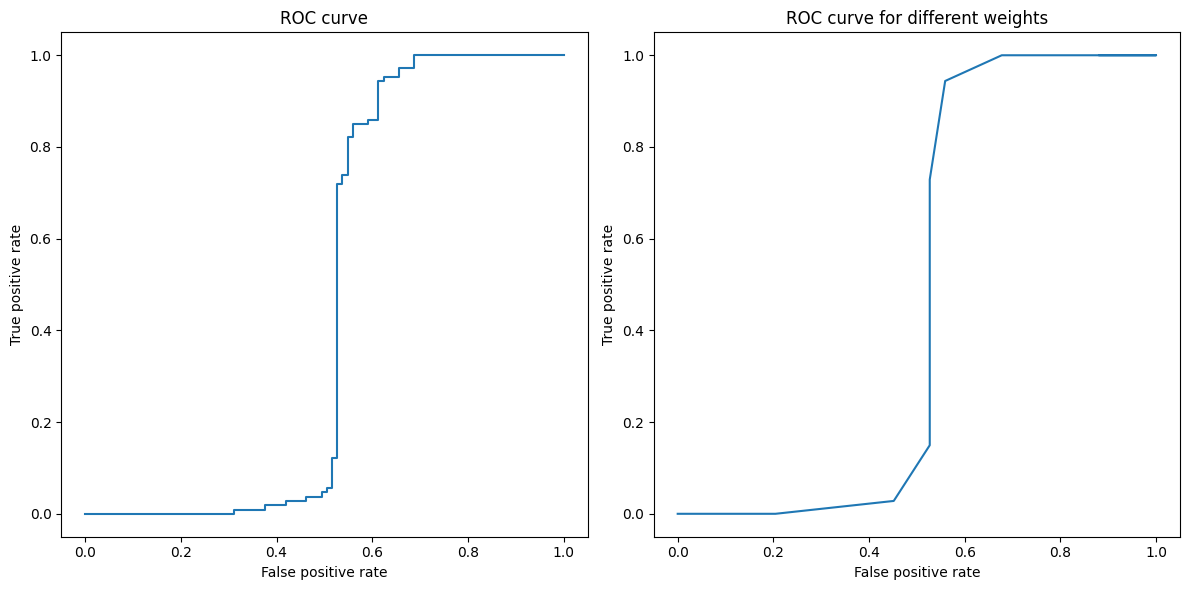

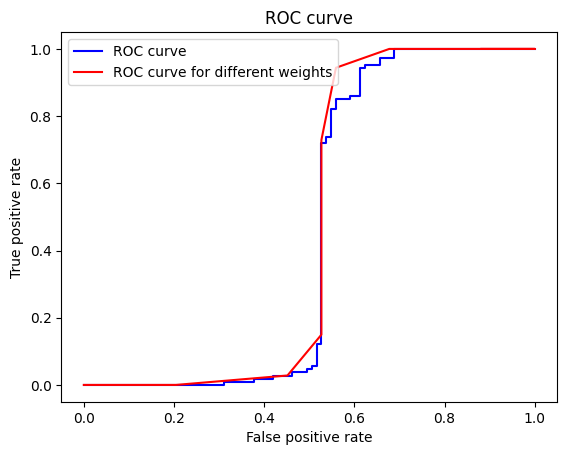

In [51]:
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(0.001, 0.999, 0.001)
majority_class_weight = 1.0 - minority_class_weight
dict_weighted_clfs = {}
for w in minority_class_weight:
    class_weights = {0: 1 - w, 1: w}

    clf_weighted = LogisticRegression(fit_intercept=False, class_weight=class_weights)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(fpr_roc, tpr_roc)
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve')
ax[1].plot([v["fpr"] for v in dict_weighted_clfs.values()], [v["tpr"] for v in dict_weighted_clfs.values()])
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve for different weights')


plt.tight_layout()
plt.show()

# Plot both the curves on the same plot figure
plt.figure()
figsize=(12, 12)
plt.plot(fpr_roc, tpr_roc, label='ROC curve',color='blue')
plt.plot([v["fpr"] for v in dict_weighted_clfs.values()], [v["tpr"] for v in dict_weighted_clfs.values()], label='ROC curve for different weights',color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()


### Analysis of the beta values

The current belief is that the $\beta_0$ values should remain constant for both the RoC curve estimates. Now we will plot the log-odds graph of the different estimates.

In [52]:
dict_weighted_clfs[0.5]["model"].coef_[0]

array([-0.06738189,  0.00592374,  0.00071425])

In [53]:
dict_weighted_clfs[0.5]["model"].intercept_

array([0.])

<Figure size 640x480 with 0 Axes>

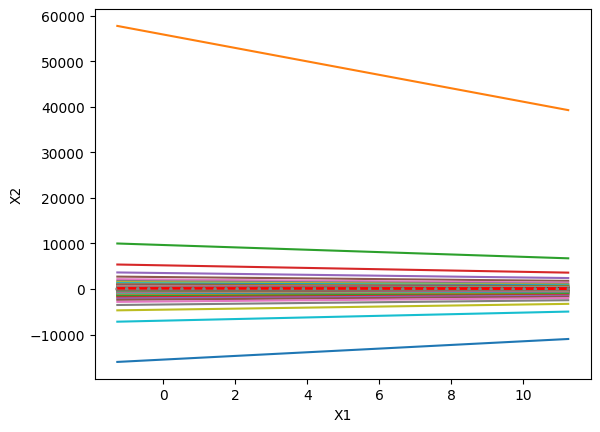

<Figure size 640x480 with 0 Axes>

In [54]:
for w in minority_class_weight:
    beta_weighted = dict_weighted_clfs[w]['model'].coef_[0]
    beta = clf.coef_[0]
    #plot the line using beta and intercept
    x = np.linspace(X_test[:,1].min(), X_test[:,1].max(), 100)
    y = -(beta_weighted[0] + beta_weighted[1] * x) / beta_weighted[2]
    y1 = -(beta[0] + beta[1] * x) / beta[2]
    plt.plot(x, y, label=f'Weight: {w:.2f}')
    plt.plot(x, y1, label='Unweighted', color='red', linestyle='dashed')
    #print(beta)
plt.xlabel('X1')
plt.ylabel('X2')
plt.figure()


## Plot the decision boundaries

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf_model, X, y, weight_index_to_plot):
    # Assuming X has shape (n_samples, 3) [intercept, predictor1, predictor2]
    # and y has shape (n_samples,)

    w = clf_model.coef_[0]  #Extract weights including intercept

    # Decision boundary: w0 + w1*x1 + w2*x2 = 0  => x2 = -(w0 + w1*x1) / w2

    x1 = np.array([X[:,1].min(), X[:,1].max()]) #range of predictor 1
    x2 = -(w[0] + w[1] * x1) / w[2]  #Calculate corresponding predictor 2

    y1 = -(beta[0] + beta[1] * x1) / beta[2] #original beta values
    
    plt.plot(x1, x2, 'k--', linewidth=0.5)
    plt.plot(x1, y1, 'r--')
    plt.annotate(weight_index_to_plot, xy=(x1.mean(), x2.mean()), xytext=(x1.mean() + 1, x2.mean() + 1))
    plt.xlabel('Predictor 1')
    plt.ylabel('Predictor 2')
    #plt.legend()
    plt.title('Decision Boundary on Test Data')
    #plt.show()



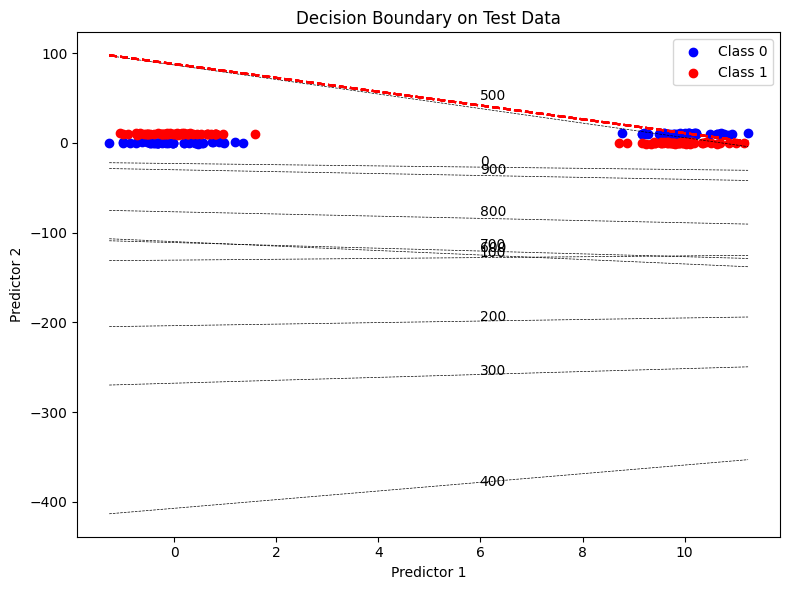

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6)) # Single plot, no need for multiple subplots


for weight_index_to_plot in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:
    w = minority_class_weight[weight_index_to_plot]
    model = dict_weighted_clfs[w]["model"]
    plot_decision_boundary(model, X_test, y_test, weight_index_to_plot)

plt.scatter(X_test[y_test == 0, 1], X_test[y_test == 0, 2], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 1], X_test[y_test == 1, 2], color='r', label='Class 1') 

plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

* 1. For the simple logistic regression function, the RoC curve either generated by changing the threshold or by changing the weights generate similar results.
* 2. Changing weights take longer to execute